In [58]:
import scanpy as sc
import os
import numpy as np


import sys
sys.path.append('../Utils')
sys.path.insert(0, '../../FRLC/src/')
import warnings
warnings.filterwarnings("ignore")


import Solve_Slice_test
from Solve_Slice_test import find_B, solve_V_per_slice, laplacian_from_coords, solve_V_all_slices, find_B_music
from Solve_Slice_test import select_informative_genes
from Plot_utils import global_cluster_then_per_slice_ari, plot_mass_transport_heatmap,plot_slices_horizontal_centered

from jobs_brain import prepare_data

from Impute import compare_imputation_midpoint, pca_align_then_temporal_flip, rotate_points


import anndata as ad
import numpy as np
import scanpy as sc
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data. 

Change fname according to local directories. The data is downloaded from:
https://db.cngb.org/stomics/mosta/download/

The resulting adata_insamp is a list of adata objects containing spatial transcriptomics. pd_B is the reference matrix representing mean expression for cell types. 

In [7]:
adata_insamp, pd_B = prepare_data(threshold=1.25, return_sc=False, fname="../../../Data/MOSTA/Dorsal_midbrain_cell_bin.h5ad" )

FP200000600TR_E3
E12.5
SS200000108BR_B1B2
E14.5
SS200000108BR_A3A4
E16.5
SS200000131BL_C3C4
E16.5
SS200000131BL_C5C6
E16.5
11851


# Run ATLIS. 

In [35]:
V, pi, aux = solve_V_all_slices(
                        adata_insamp, pd_B,
                        lam=1e3, mu=1e2, 
                        verbose=False,
                        ot_solver='low_rank',
                        alpha = 0.5
                    )

iter    0  f=1.815166e+06  rel_drop=9.991e-01  mean step=5.18e-06
iter   50  f=1.495461e+06  rel_drop=1.316e-05  mean step=4.89e-06
iter   55  f=1.495379e+06  rel_drop=9.664e-06  mean step=4.88e-06
stopped after iteration # 55
iter    0  f=7.688469e+05  rel_drop=9.996e-01  mean step=5.18e-06
iter   50  f=5.567100e+05  rel_drop=3.066e-04  mean step=8.34e-06
iter  100  f=5.536420e+05  rel_drop=3.268e-05  mean step=8.39e-06
iter  139  f=5.532506e+05  rel_drop=9.826e-06  mean step=8.39e-06
stopped after iteration # 139
iter    0  f=1.854643e+06  rel_drop=9.995e-01  mean step=5.19e-06
iter   50  f=1.073919e+06  rel_drop=1.398e-03  mean step=9.96e-06
iter  100  f=1.041544e+06  rel_drop=2.348e-04  mean step=1.02e-05
iter  150  f=1.035000e+06  rel_drop=6.461e-05  mean step=1.02e-05
iter  200  f=1.032942e+06  rel_drop=2.394e-05  mean step=1.02e-05
iter  250  f=1.032112e+06  rel_drop=1.062e-05  mean step=1.02e-05
iter  255  f=1.032060e+06  rel_drop=9.865e-06  mean step=1.02e-05
stopped after ite

In [36]:

ari_avg = 0
import matplotlib.pyplot as plt
out = global_cluster_then_per_slice_ari(
            V,
            adata_insamp,
            celltype_key="annotation",
            embedding_key="spatial",
            clustering="louvain",
            plot=False,
            auto_mode='match_k',
            return_pred=True
)

print(out["mean_ari"])
ari_ours = np.asarray(list(out["per_slice_ari"].values()), dtype=float)
nmi_ours = np.asarray(list(out["per_slice_nmi"].values()), dtype=float)
for i in range(3):
    adata_insamp[i].obs['ours'] = out['pred_labels'][i]

ari_global_ours = out["global_ari"]
nmi_global_ours = out["global_nmi"]


Louvain: target_k=11, best_resolution=0.307, n_clusters=11
0.32642506290404905


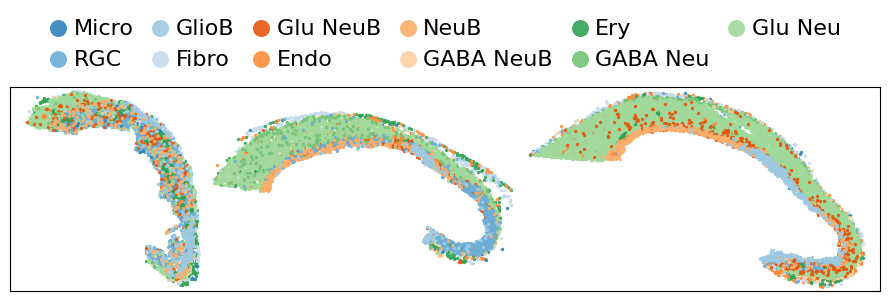

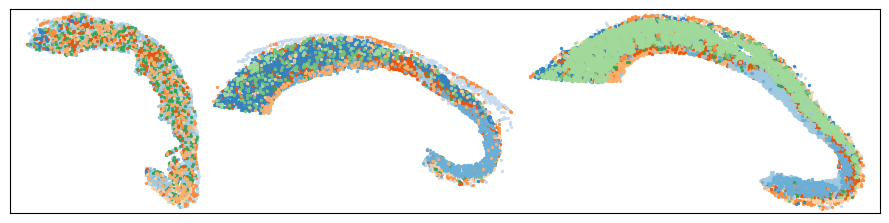

In [38]:
cmap = 'tab20c'
fig, ax = plot_slices_horizontal_centered(
    adata_list=adata_insamp,
    obs_key="annotation",
    coord_keys=("x", "y"),      # uses ad.obs['x'], ad.obs['y'] if present
    obsm_key="spatial",         # otherwise uses ad.obsm['spatial'][:, :2]
    order_key=None,     # optional; requires each slice has exactly one time_point
    # order_map={"E10.5": 10.5, "E11.5": 11.5},  # optional helper
    y_scale=1.0,
    x_gap = 1050,
    s=6,
    legend_loc='upper center',
    legend_bbox=(0.5,0.8),
    legend_ncol = 6,
    legend_font=16,
    truth_key="ours",
    truth_cmap=cmap
)
plt.show()

fig, ax = plot_slices_horizontal_centered(
    adata_list=adata_insamp,
    obs_key="ours",
    coord_keys=("x", "y"),      # uses ad.obs['x'], ad.obs['y'] if present
    obsm_key="spatial",         # otherwise uses ad.obsm['spatial'][:, :2]
    order_key=None,     # optional; requires each slice has exactly one time_point
    # order_map={"E10.5": 10.5, "E11.5": 11.5},  # optional helper
    y_scale=1.0,
    x_gap = 1050,
    s=6,
    legend=False,
    truth_key="ours",
    truth_cmap=cmap
)
plt.show()


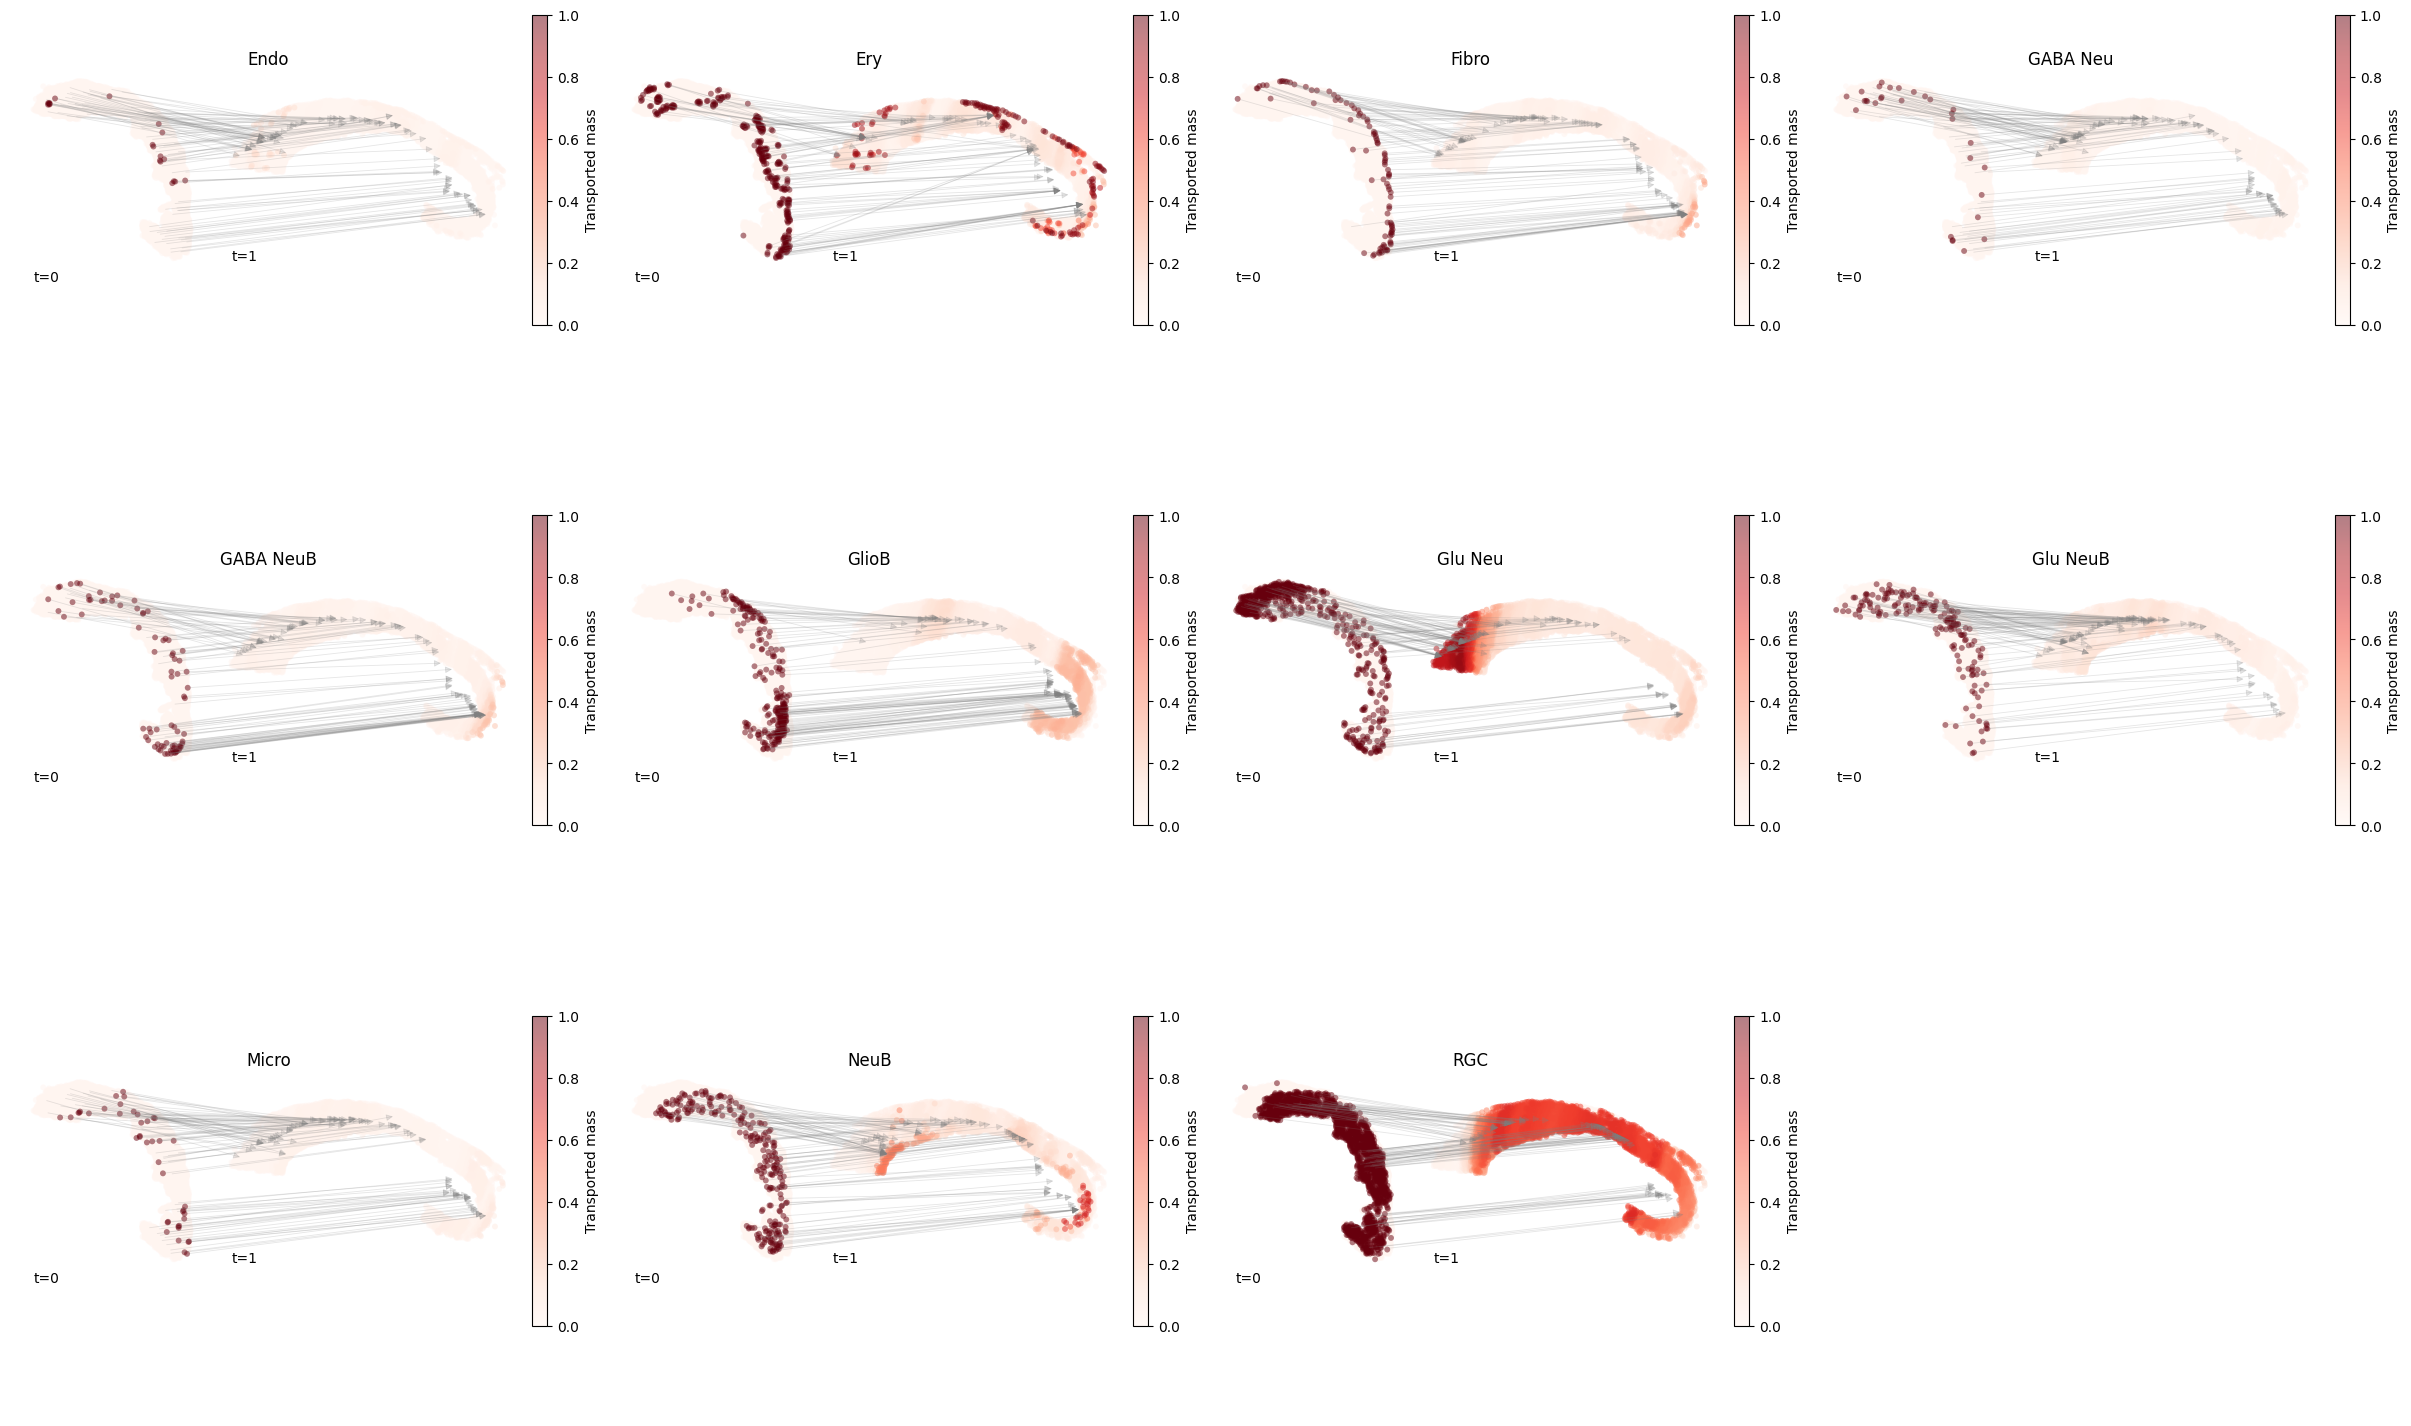

In [43]:
import math
cell_types = list(adata_insamp[0].obs["annotation"].unique())
cell_types = sorted(cell_types)   
n = len(cell_types)

ncols = 4                         
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6 * ncols, 5 * nrows),   
    constrained_layout=True
)


axes = np.asarray(axes).reshape(-1)


for i, cell_type in enumerate(cell_types):
    ax = axes[i]

    
    fig_i, ax_i, masses = plot_mass_transport_heatmap(
        adata_insamp,
        V,
        pi,
        t_start=0,
        t_end=1,
        source_celltype=cell_type,
        celltype_obs_key="annotation",
        source_mass_source="obs",
        y_gap=4800,
        y_scale=1.0,
        show_edges=True,
        n_sources_show = 100,
        alpha=0.5,
        cmap="Reds",
        edge_alpha=0.2,
        ax=ax,          
        fig=fig,        
       
    )

    ax.set_title(str(cell_type), fontsize=12)

# --- 4) Turn off any unused axes (if grid > n)
for j in range(n, len(axes)):
    axes[j].axis("off")

# Now try an interpolation between the first and last slices

In [51]:
i = 1
X_all, V_all, t_grid, gw_dists = compare_imputation_midpoint(adata_insamp, V, pd_B, i, n_end=1000)



a=0,b=16
a=0,b=8
a=8,b=16
a=0,b=4
a=4,b=8
a=8,b=12
a=12,b=16
a=0,b=2
a=2,b=4
a=4,b=6
a=6,b=8
a=8,b=10
a=10,b=12
a=12,b=14
a=14,b=16
t = 0.062500
GW = 0.008941325769915888
t = 0.125000
GW = 0.006901447127785597
t = 0.187500
GW = 0.005160286805886312
t = 0.250000
GW = 0.003670206236170456
t = 0.312500
GW = 0.002513954080953474
t = 0.375000
GW = 0.0016192249827116625
t = 0.437500
GW = 0.0010191103318388625
t = 0.500000
GW = 0.0006926149344549961
t = 0.562500
GW = 0.0006220920612545752
t = 0.625000
GW = 0.0008363754608632257
t = 0.687500
GW = 0.001349350111684257
t = 0.750000
GW = 0.0021707238891667713
t = 0.812500
GW = 0.003280999759285605
t = 0.875000
GW = 0.004702356804272012
t = 0.937500
GW = 0.006423052261927401


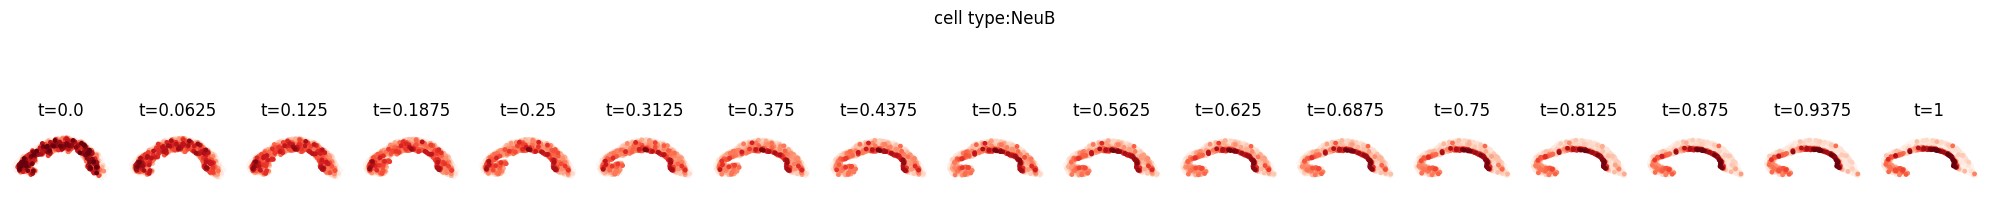

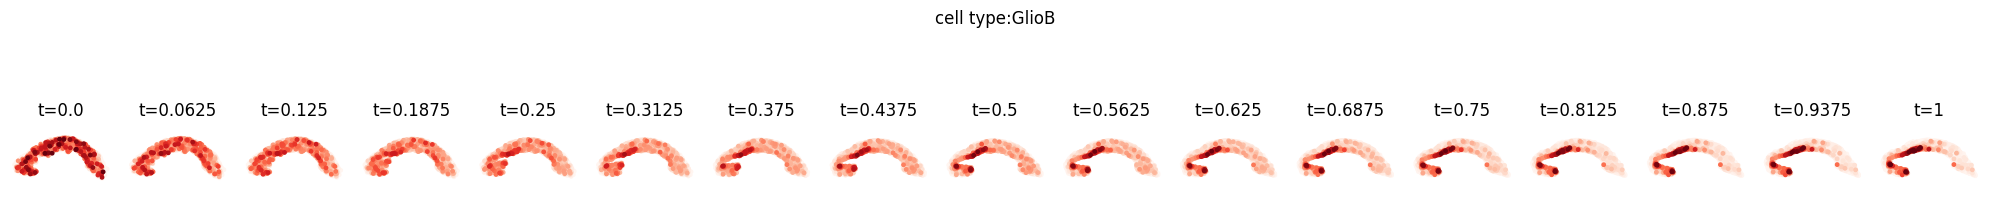

In [67]:
import matplotlib.pyplot as plt
type_id = -2
i = 1
plt.rcParams['figure.figsize'] = (20,2)
plt.rcParams['font.size'] = 10
t_grid = list(np.array(range(16))*1/16) + [1]
ad0, adt, ad1 = adata_insamp[i - 1], adata_insamp[i], adata_insamp[i + 1]


V0 = np.asarray(V[i - 1], float)
Vt = np.asarray(V[i], float)
V1 = np.asarray(V[i + 1], float)

def coords(ad):
        return ad.obs[["x", "y"]].to_numpy(dtype=float)

X0 = coords(ad0)
Xt = coords(adt)
X1 = coords(ad1)

for counter in range(len(t_grid)):
        
        Ybar = V_all[counter+3]
        Xbar = X_all[counter+3]
        
        Xbar = pca_align_then_temporal_flip(Xbar, Xt)
        if counter >= 5:
                Xbar[:,0] = -Xbar[:,0]
        # if counter == 5:
        #         Xbar[:,0] = -Xbar[:,0]

        plt.subplot(2,len(t_grid),len(t_grid) + 1+counter)
        Ybar = Ybar / np.sum(Ybar,axis=1).reshape(-1,1)
        order = np.argsort(Ybar[:,type_id])
        plt.scatter(Xbar[order,0],Xbar[order,1], c=Ybar[order,type_id], s=6, cmap='Reds')
        plt.title('t='+str(t_grid[counter]))
        plt.clim([0,1])
        plt.axis('off')
        plt.axis('equal')
plt.tight_layout()
plt.suptitle('cell type:' + pd_B.index[type_id] )
plt.show()


type_id = -1

for counter in range(len(t_grid)):
        
        Ybar = V_all[counter+3]
        Xbar = X_all[counter+3]
        
        Xbar = pca_align_then_temporal_flip(Xbar, Xt)
        if counter >= 5:
                Xbar[:,0] = -Xbar[:,0]
        # if counter == 5:
        #         Xbar[:,0] = -Xbar[:,0]

        plt.subplot(2,len(t_grid),len(t_grid) + 1+counter)
        Ybar = Ybar / np.sum(Ybar,axis=1).reshape(-1,1)
        order = np.argsort(Ybar[:,type_id])
        plt.scatter(Xbar[order,0],Xbar[order,1], c=Ybar[order,type_id], s=6, cmap='Reds')
        plt.title('t='+str(t_grid[counter]))
        plt.clim([0,1])
        plt.axis('off')
        plt.axis('equal')
plt.tight_layout()
plt.suptitle('cell type:' + pd_B.index[type_id] )
plt.show()

# To inspect a specific gene:

[6647 6644 6640 ... 3377 3661 3140]
[3636 3633   14 ...  820 2037  767]


Text(0.5, 0.98, 'gene expression: Fabp7')

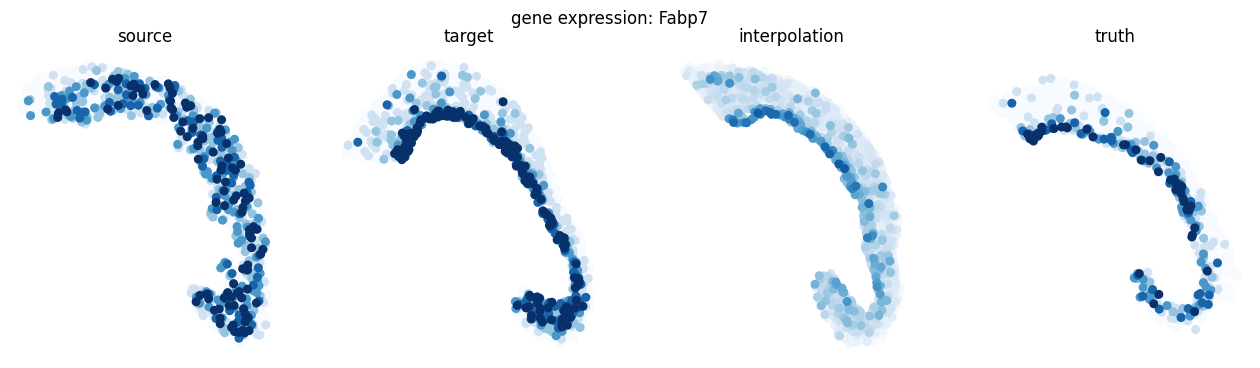

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def coords(ad):
    return ad.obs[["x", "y"]].to_numpy(dtype=float)

counter = 9
Ybar = V_all[counter+3]

Xbar = X_all[counter+3]

common_genes = adata_insamp[1].var_names.intersection(pd_B.columns)
adata_sub = adata_insamp[1][:, common_genes].copy()
pd_B_sub = pd_B.loc[:, common_genes]
Xt = coords(adata_sub)
Yt = adata_sub.X.todense()
Y_bar_gene = Ybar @ pd_B_sub.values

Xt = coords(adata_insamp[1])
Yt = adata_insamp[1][:,pd_B_sub.columns].X.todense()


adata_sub = adata_insamp[0][:, common_genes].copy()
pd_B_sub = pd_B.loc[:, common_genes]
Xt1 = coords(adata_sub)
Yt1 = adata_sub.X.todense()

adata_sub = adata_insamp[2][:, common_genes].copy()
pd_B_sub = pd_B.loc[:, common_genes]
Xt2 = coords(adata_sub)
Yt2 = adata_sub.X.todense()

plt.rcParams['figure.figsize'] = (16,4)
plt.subplot(1,4,1)
gene = 156
order = np.argsort(np.array(Yt1[:,gene]).ravel())
order = order[::3]
plt.scatter(Xt1[order,0], Xt1[order,1], c=np.array(Yt1[order,gene]), s=30, cmap='Blues')
plt.clim([0,5])
plt.axis('off')
# plt.axis('equal')
plt.title('source')
plt.subplot(1,4,2)
order = np.argsort(np.array(Yt2[:,gene]).ravel())
order = order[::3]
print(order)
plt.scatter(Xt2[order,0], Xt2[order,1], c=np.array(Yt2[order,gene]), s=30, cmap='Blues')
plt.axis('off')
plt.clim([0,5])
plt.title('target')


plt.subplot(1,4,3)
Xbar = X_all[counter+3]
Xt = coords(adata_insamp[1])

Xbar = pca_align_then_temporal_flip(Xbar, Xt)
Xbar = rotate_points(Xbar, angle_deg=-60, center=Xbar.mean(axis=0))
Y_bar_gene = Y_bar_gene / Y_bar_gene.sum(axis=1).reshape(-1,1) * Yt.sum(axis=1).mean()


order = np.argsort(Y_bar_gene[:,gene])
plt.scatter(Xbar[order,0], Xbar[order,1], c=Y_bar_gene[order,gene], s=30, cmap='Blues')
plt.clim([0,5])
plt.axis('off')
plt.axis('equal')
plt.title('interpolation')
plt.subplot(1,4,4)
order = np.argsort(np.array(Yt[:,gene]).ravel())
order = order[::3]
print(order)
Xt = rotate_points(Xt, angle_deg=-35, center=Xbar.mean(axis=0))
plt.scatter(Xt[order,0], Xt[order,1], c=np.array(Yt[order,gene]), s=30, cmap='Blues')
plt.axis('off')
plt.axis('equal')
plt.clim([0,5])
plt.title('truth')

plt.suptitle('gene expression: ' + adata_insamp[0].var_names[gene] )